## 1. Setup & Config

In [34]:
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict

config = {
    "episode_id": "Monday_11AM",
    "num_classrooms": 6,
    "attendance": [100, 95, 20, 80, 35, 50],
    "bottleneck": {
        "capacity_per_minute": 30,
        "batch_duration_min": 2
    },
    "time_offsets": [0, -2, 2, -4, 4, -6, 6],
    "time_offsets": [0, 0, 0, 0, 0, 0, 0],
    "max_negotiation_rounds": 5,
    "violation_threshold": 3,
    "random_seed": 42
}

random.seed(config["random_seed"])


## 2. Define Message Schemas

In [35]:
@dataclass
class CapacityBroadcast:
    cap_per_min: int
    total_estimate: int
    episode_id: str

@dataclass
class Offer:
    offer_id: str
    from_id: str
    to_id: str
    shift_min: int
    moved_students: int
    trade_credit: int
    episode_id: str

@dataclass
class Accept:
    offer_id: str
    from_id: str
    to_id: str
    episode_id: str

@dataclass
class Reject:
    offer_id: str
    from_id: str
    to_id: str
    reason: str
    episode_id: str

## 3. Bottleneck Agent

In [36]:
class BottleneckAgent:
    def __init__(self, config):
        self.cap_per_min = config["bottleneck"]["capacity_per_minute"]
        self.batch_duration = config["bottleneck"]["batch_duration_min"]
        self.per_batch = self.cap_per_min * self.batch_duration

    def broadcast_capacity(self, attendance_list, episode_id):
        total_estimate = sum(attendance_list)
        msg = CapacityBroadcast(self.cap_per_min, total_estimate, episode_id)
        return msg

## 4. Classroom Agent

In [37]:


class ClassroomAgent:
    def __init__(self, id, attendance, config, professor_willingness=0.7):
        self.id = id
        self.attendance = attendance
        self.config = config
        self.professor_willingness = professor_willingness
        self.commitment_history = []
        self.planned_slots = [(0, attendance)]
        self.per_batch = config["bottleneck"]["capacity_per_minute"] * config["bottleneck"]["batch_duration_min"]

    def on_capacity_broadcast(self, msg: CapacityBroadcast, index=0):
        offsets = self.config["time_offsets"]
        chosen_offset = offsets[index % len(offsets)]
        take = min(self.attendance, self.per_batch)
        self.planned_slots = [(chosen_offset, take)]

    def propose_shift(self, target_agent, congestion_offset):
        if random.random() < self.professor_willingness:
            shift = random.choice([-2, 2])
            offer = Offer(
                offer_id=f"offer_{self.id}_{target_agent.id}",
                from_id=self.id,
                to_id=target_agent.id,
                shift_min=shift,
                moved_students=min(self.attendance, self.per_batch),
                trade_credit=1,
                episode_id=self.config["episode_id"]
            )
            return offer
        else:
            return None

    def apply_offer(self, offer: Offer):
        """Accept offer only if I am the intended receiver"""
        if self.id != offer.to_id:
            return
        new_slots = []
        for offset, count in self.planned_slots:
            new_slots.append((offset + offer.shift_min, count))
        self.planned_slots = new_slots
        self.commitment_history.append(offer)

    def broadcast_schedule(self):
        return {"id": self.id, "slots": self.planned_slots}

##  NEGOTIATION SIMULATION

In [38]:
B = BottleneckAgent(config)
classrooms = [
    ClassroomAgent(f"C{i+1}", config["attendance"][i], config)
    for i in range(config["num_classrooms"])
]

# Step 1: Capacity broadcast
msg = B.broadcast_capacity(config["attendance"], config["episode_id"])

# Step 2: Initial slot assignment
for i, c in enumerate(classrooms):
    c.on_capacity_broadcast(msg, index=i)

# Step 3: Negotiation loop
for round_ in range(config["max_negotiation_rounds"]):
    # Count students per slot
    slot_map: Dict[int, int] = {}
    for c in classrooms:
        for offset, count in c.planned_slots:
            slot_map[offset] = slot_map.get(offset, 0) + count

    congested_offsets = [off for off, val in slot_map.items() if val > B.per_batch]

    if not congested_offsets:
        print(f"No congestion after round {round_}")
        break

    for off in congested_offsets:
        congested_agents = [c for c in classrooms if any(s[0] == off for s in c.planned_slots)]
        if len(congested_agents) >= 2:
            a1, a2 = congested_agents[:2]
            offer = a1.propose_shift(a2, off)
            if offer:
                print(f"{a1.id} proposes to {a2.id}: shift {offer.shift_min} min")
                # apply shift to the target (receiver)
                a2.apply_offer(offer)
                # record agreement in proposer’s history too
                a1.commitment_history.append(offer)


# Step 4: Final schedules
schedules = [c.broadcast_schedule() for c in classrooms]
for s in schedules:
    print(s)


C1 proposes to C2: shift -2 min
C1 proposes to C3: shift -2 min
C2 proposes to C3: shift -2 min
C1 proposes to C4: shift -2 min
{'id': 'C1', 'slots': [(0, 60)]}
{'id': 'C2', 'slots': [(-2, 60)]}
{'id': 'C3', 'slots': [(-4, 20)]}
{'id': 'C4', 'slots': [(-2, 60)]}
{'id': 'C5', 'slots': [(0, 35)]}
{'id': 'C6', 'slots': [(0, 50)]}


## Visualization

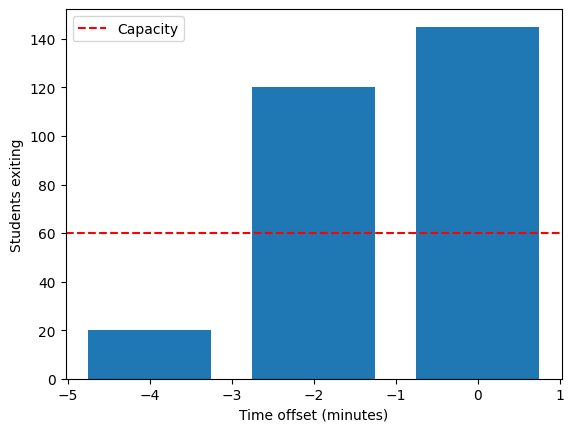

In [39]:

slot_map = {}
for sched in schedules:
    for offset, count in sched["slots"]:
        slot_map[offset] = slot_map.get(offset, 0) + count

plt.bar(slot_map.keys(), slot_map.values(), width=1.5)
plt.axhline(B.per_batch, color="red", linestyle="--", label="Capacity")
plt.xlabel("Time offset (minutes)")
plt.ylabel("Students exiting")
plt.legend()
plt.show()